In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob

%matplotlib inline

In [146]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
labels_df = pd.read_csv('/content/drive/MyDrive/Head CT Hemorrhage detection with Tensorflow/labels.csv')
labels = np.array(labels_df[' hemorrhage'].tolist())

files = sorted(glob.glob('/content/drive/MyDrive/Head CT Hemorrhage detection with Tensorflow/head_ct/head_ct/*.png'))
images = np.array([cv2.imread(path) for path in files])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


# Initial data exploration

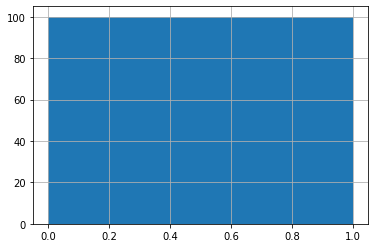

In [148]:
labels_df[' hemorrhage'].hist(bins=2)

There is the same amount of data for both cases.

Images are not the same sizes! We need to find the optimal size, but before we have to explore it.

In [149]:
images_df = pd.DataFrame(images, columns=['image'])

In [150]:
images_df['width'] = images_df['image'].apply(lambda x: x.shape[0])
images_df['height'] = images_df['image'].apply(lambda x: x.shape[1])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38eea5b4d0>,
      dtype=object)

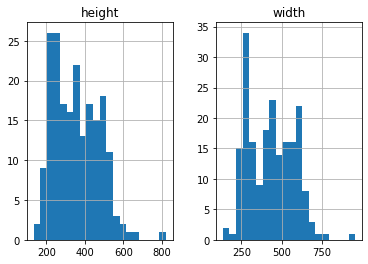

In [151]:
images_df[['height', 'width']].hist(bins=20)

In [152]:
images_df[['height', 'width']].describe()

,height,width
count,200.000000,200.000000
mean,355.505000,433.720000
std,116.785247,142.059481
min,134.000000,135.000000
25%,252.000000,298.750000
50%,345.000000,435.500000
75%,447.250000,554.000000
max,821.000000,957.000000


In [153]:
images = np.array([cv2.resize(image, (128, 128)) for image in images])

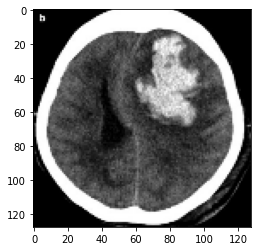

In [154]:
plt.imshow(images[0])

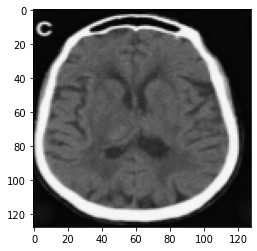

In [155]:
plt.imshow(images[100])

The quality of images seems to be acceptable.

# Adding flipped images

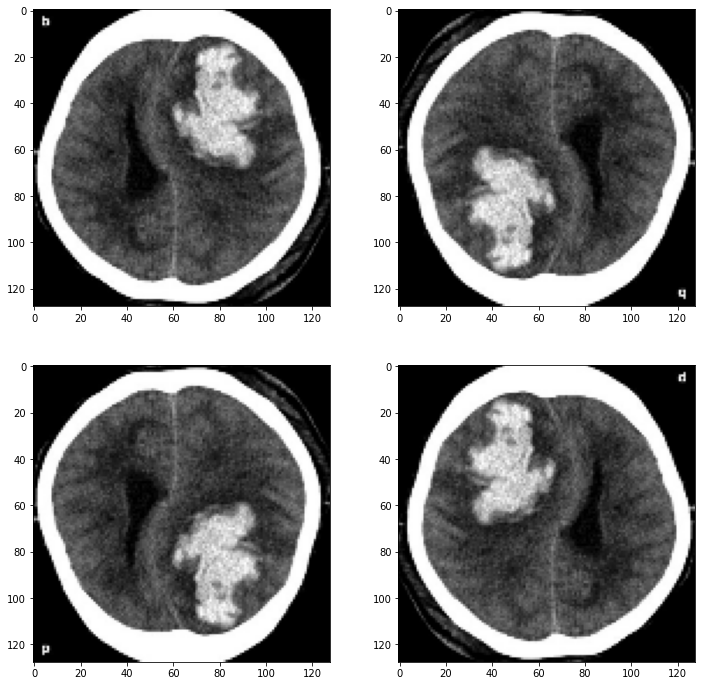

In [156]:
plt.figure(figsize=(12, 12))
for i, flip in enumerate([None, -1, 0, 1]):
    plt.subplot(221 + i)
    if flip is None:
        plt.imshow(images[0])
    else:
        plt.imshow(cv2.flip(images[0], flip))

In [157]:
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [158]:
# since data is strictly true until index 100 and then strictly false,
# we can take random 90 entries from frist half and then random 90 from the second half
# to have evenly distributed train and test sets
indicies = np.random.permutation(100)
train_true_idx, test_true_idx = indicies[:90], indicies[90:]
train_false_idx, test_false_idx = indicies[:90] + 100, indicies[90:] + 100
train_idx, test_idx = np.append(train_true_idx, train_false_idx), np.append(test_true_idx, test_false_idx)

train_validationX, train_validationY = images[train_idx], labels[train_idx]
testX, testY = images[test_idx], labels[test_idx]

print(train_validationX.shape, testX.shape)
print(train_validationY.shape, testY.shape)

(180, 128, 128, 3) (20, 128, 128, 3)
(180,) (20,)


In [159]:
# now to split train and validation sets
tr_len = train_validationX.shape[0]
train_val_split = int(tr_len*0.9)
indicies = np.random.permutation(tr_len)
train_idx, validation_idx = indicies[:train_val_split], indicies[train_val_split:]

trainX, trainY = train_validationX[train_idx], train_validationY[train_idx]
validationX, validationY = train_validationX[validation_idx], train_validationY[validation_idx]

print(trainX.shape, validationX.shape)
print(trainY.shape, validationY.shape)

(162, 128, 128, 3) (18, 128, 128, 3)
(162,) (18,)


In [160]:
import keras

In [161]:
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam

import math

# Image augmentation

In [162]:
train_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)
validation_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=90,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0)

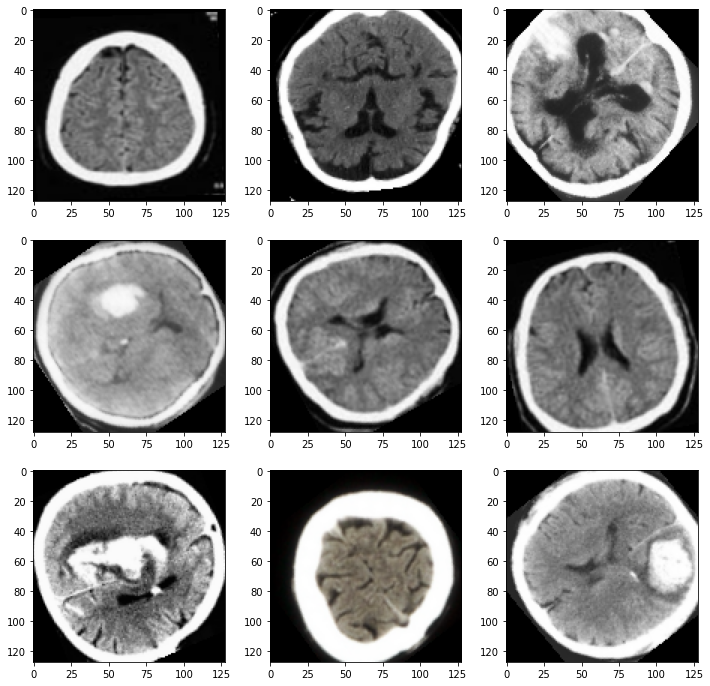

In [163]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_image_data.flow(trainX, trainY, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.show()
    break

# Building the model

In [164]:
def check_accuracy(model, setX, actual, print_images=True):
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)])
    if print_images:
        rows = math.ceil(len(predicted)/10.)
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)):
            plt.subplot(rows, 10, i+1)
            plt.imshow(setX[i])
            plt.title("pred "+str(predicted[i])+" actual "+str(actual[i]))
        
    confusion = confusion_matrix(actual, predicted)
    tn, fp, fn, tp = confusion.ravel()
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", np.sum(predicted==actual) / len(predicted) * 100., "%")
    return (tn, fp, fn, tp)

In [165]:
models=[]
acc=[]

## Cnn Model

In [166]:
def simple_conv_model1(input_shape):
    model1 = Sequential()
    
    model1.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model1.add(MaxPooling2D(pool_size=2))
    model1.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model1.add(MaxPooling2D(pool_size=2))
    model1.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model1.add(GlobalAveragePooling2D())
    model1.add(Dropout(0.4))
    
    model1.add(Dense(32, activation='relu'))
    model1.add(Dropout(0.4))
    
    model1.add(Dense(1, activation='sigmoid'))
    return model1

In [167]:
model1 = simple_conv_model1((128, 128, 3))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [168]:
models.append("Simple CNN")
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_291 (Conv2D)         (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_292 (Conv2D)         (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_293 (Conv2D)         (None, 4, 4, 64)          18496     
                                                                 
 global_average_pooling2d_3   (None, 64)              

## Resnet50

In [169]:
import tensorflow
from tensorflow.keras.applications import ResNet50
base_model2=ResNet50(input_shape=(128,128,3),include_top=False, weights='imagenet', pooling='max')
for layer in base_model2.layers:
  layer.trainable=False
x2=Flatten()(base_model2.output)
x2=Dense(512,activation='relu')(x2)
x2=Dropout(0.2)(x2)
x2=Dense(1,activation='sigmoid')(x2)
model2=tensorflow.keras.Model(base_model2.input,x2)
models.append("ResNet50")
model2.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_13[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [170]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Inception V3

In [171]:
from tensorflow.keras.applications import InceptionV3
base_model3=InceptionV3(input_shape=(128,128,3),include_top=False, weights='imagenet', pooling='max')
for layer in base_model3.layers:
  layer.trainable=False
x3=Flatten()(base_model3.output)
x3=Dense(512,activation='relu')(x3)
x3=Dropout(0.2)(x3)
x3=Dense(1,activation='sigmoid')(x3)
model3=tensorflow.keras.Model(base_model3.input,x3)
models.append("InceptionV3")
model3.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_294 (Conv2D)            (None, 63, 63, 32)   864         ['input_14[0][0]']               
                                                                                                  
 batch_normalization_282 (Batch  (None, 63, 63, 32)  96          ['conv2d_294[0][0]']             
 Normalization)                                                                                   
                                                                                           

In [172]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## DenseNet

In [173]:
from tensorflow.keras.applications import DenseNet121
base_model4=DenseNet121(input_shape=(128,128,3),include_top=False, weights='imagenet', pooling='max')
for layer in base_model4.layers:
  layer.trainable=False
x4=Flatten()(base_model4.output)
x4=Dense(512,activation='relu')(x4)
x4=Dropout(0.2)(x4)
x4=Dense(1,activation='sigmoid')(x4)
model4=tensorflow.keras.Model(base_model4.input,x4)
models.append("DenseNet121")
model4.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, 134, 134, 3)  0          ['input_15[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d_12[0][0]']      
                                                                                           

In [174]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## VGG19

In [175]:
from tensorflow.keras.applications import VGG19
base_model5=DenseNet121(input_shape=(128,128,3),include_top=False, weights='imagenet', pooling='max')
for layer in base_model5.layers:
  layer.trainable=False
x5=Flatten()(base_model5.output)
x5=Dense(512,activation='relu')(x5)
x5=Dropout(0.2)(x5)
x5=Dense(1,activation='sigmoid')(x5)
model5=tensorflow.keras.Model(base_model5.input,x5)
models.append("VGG19")
model5.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_14 (ZeroPadding  (None, 134, 134, 3)  0          ['input_16[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d_14[0][0]']      
                                                                                           

In [176]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training model

## Simple CNN model

In [177]:
batchSize = 32
metric = 'val_accuracy'
model1.fit(train_image_data.flow(trainX, trainY, batch_size=batchSize), validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    #callbacks=[ModelCheckpoint("weights.h5", monitor=metric, save_best_only=True, mode='max', verbose=1)],
    epochs=16)

Epoch 1/16
6/6 [==============================] - 2s 145ms/step - loss: 0.6991 - accuracy: 0.4691 - val_loss: 0.6923 - val_accuracy: 0.5556
Epoch 2/16
6/6 [==============================] - 1s 99ms/step - loss: 0.6935 - accuracy: 0.4938 - val_loss: 0.6975 - val_accuracy: 0.3889
Epoch 3/16
6/6 [==============================] - 1s 99ms/step - loss: 0.6969 - accuracy: 0.5123 - val_loss: 0.6877 - val_accuracy: 0.6111
Epoch 4/16
6/6 [==============================] - 1s 99ms/step - loss: 0.6925 - accuracy: 0.4753 - val_loss: 0.6796 - val_accuracy: 0.6111
Epoch 5/16
6/6 [==============================] - 1s 100ms/step - loss: 0.6934 - accuracy: 0.5062 - val_loss: 0.6763 - val_accuracy: 0.6111
Epoch 6/16
6/6 [==============================] - 1s 98ms/step - loss: 0.7163 - accuracy: 0.4877 - val_loss: 0.6795 - val_accuracy: 0.6111
Epoch 7/16
6/6 [==============================] - 1s 100ms/step - loss: 0.6960 - accuracy: 0.5309 - val_loss: 0.6946 - val_accuracy: 0.3889
Epoch 8/16
6/6 [========

1/1 [==============================] - 0s 86ms/step
True positive: 0 , True negative: 7 , False positive: 0 , False negative: 11
Total accuracy: 38.88888888888889 %


(7, 0, 11, 0)

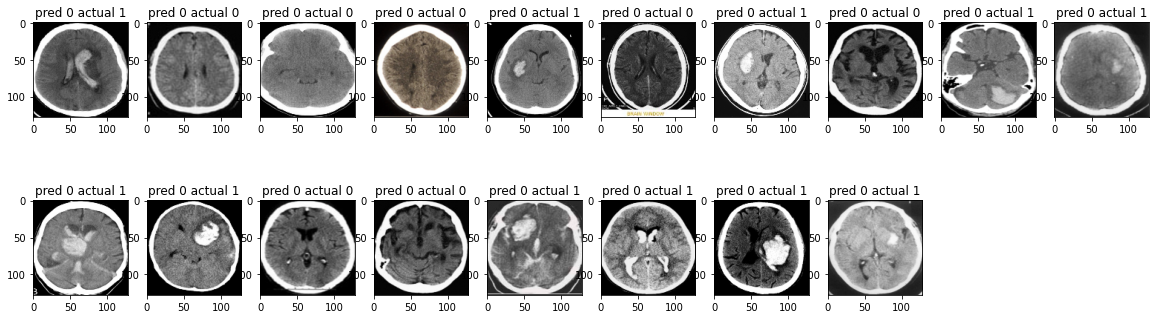

In [178]:
check_accuracy(model1, validationX/255., validationY)

In [179]:
loss1,accuracy1=model1.evaluate( validationX/255., validationY)
acc.append(accuracy1*100)

1/1 [==============================] - 0s 22ms/step - loss: 0.6965 - accuracy: 0.3889


In [180]:
print(acc)

[38.88888955116272]


## Resnet 50

In [181]:
batchSize = 32
metric = 'val_accuracy'
model2.fit(train_image_data.flow(trainX, trainY, batch_size=batchSize), validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    #callbacks=[ModelCheckpoint("weights.h5", monitor=metric, save_best_only=True, mode='max', verbose=1)],
    epochs=16)

Epoch 1/16
6/6 [==============================] - 5s 317ms/step - loss: 1.2876 - accuracy: 0.4630 - val_loss: 0.8223 - val_accuracy: 0.6111
Epoch 2/16
6/6 [==============================] - 1s 122ms/step - loss: 0.9618 - accuracy: 0.4259 - val_loss: 0.7845 - val_accuracy: 0.3889
Epoch 3/16
6/6 [==============================] - 1s 122ms/step - loss: 0.7605 - accuracy: 0.5556 - val_loss: 0.7146 - val_accuracy: 0.5556
Epoch 4/16
6/6 [==============================] - 1s 146ms/step - loss: 0.7617 - accuracy: 0.5617 - val_loss: 0.9011 - val_accuracy: 0.5556
Epoch 5/16
6/6 [==============================] - 1s 121ms/step - loss: 0.6482 - accuracy: 0.6420 - val_loss: 0.7031 - val_accuracy: 0.5556
Epoch 6/16
6/6 [==============================] - 1s 127ms/step - loss: 0.6275 - accuracy: 0.6173 - val_loss: 0.6257 - val_accuracy: 0.7778
Epoch 7/16
6/6 [==============================] - 1s 122ms/step - loss: 0.7176 - accuracy: 0.6049 - val_loss: 0.6204 - val_accuracy: 0.6111
Epoch 8/16
6/6 [====

1/1 [==============================] - 1s 860ms/step
True positive: 6 , True negative: 6 , False positive: 1 , False negative: 5
Total accuracy: 66.66666666666666 %


(6, 1, 5, 6)

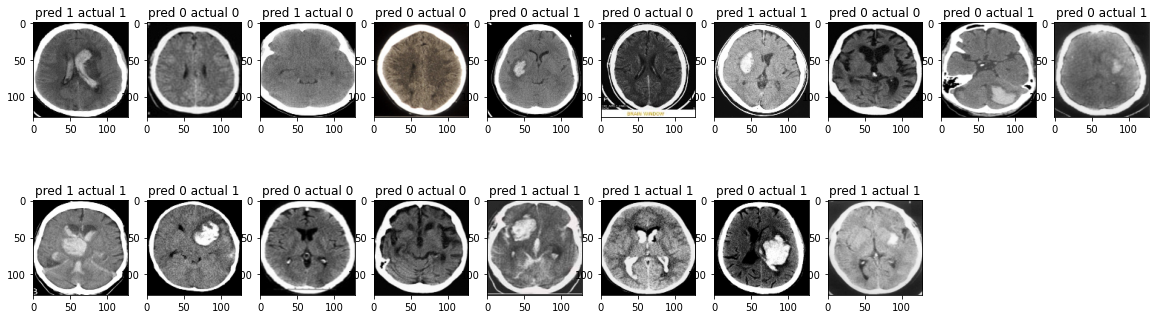

In [182]:
check_accuracy(model2, validationX/255., validationY)

In [183]:
loss2,accuracy2=model2.evaluate( validationX/255., validationY)
acc.append(accuracy2*100)

1/1 [==============================] - 0s 58ms/step - loss: 0.6222 - accuracy: 0.6667


## Inception V3

In [184]:
batchSize = 32
metric = 'val_accuracy'
model3.fit(train_image_data.flow(trainX, trainY, batch_size=batchSize), validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    #callbacks=[ModelCheckpoint("weights.h5", monitor=metric, save_best_only=True, mode='max', verbose=1)],
    epochs=16)

Epoch 1/16
6/6 [==============================] - 7s 374ms/step - loss: 4.6526 - accuracy: 0.4938 - val_loss: 0.9689 - val_accuracy: 0.6667
Epoch 2/16
6/6 [==============================] - 1s 136ms/step - loss: 0.7669 - accuracy: 0.7593 - val_loss: 1.4667 - val_accuracy: 0.6111
Epoch 3/16
6/6 [==============================] - 1s 125ms/step - loss: 0.6657 - accuracy: 0.7963 - val_loss: 1.0275 - val_accuracy: 0.7222
Epoch 4/16
6/6 [==============================] - 1s 122ms/step - loss: 0.6537 - accuracy: 0.8210 - val_loss: 0.3688 - val_accuracy: 0.7778
Epoch 5/16
6/6 [==============================] - 1s 126ms/step - loss: 0.4823 - accuracy: 0.8272 - val_loss: 0.5107 - val_accuracy: 0.7778
Epoch 6/16
6/6 [==============================] - 1s 134ms/step - loss: 0.5278 - accuracy: 0.7901 - val_loss: 0.2608 - val_accuracy: 0.8889
Epoch 7/16
6/6 [==============================] - 1s 128ms/step - loss: 0.5061 - accuracy: 0.8148 - val_loss: 0.5170 - val_accuracy: 0.8333
Epoch 8/16
6/6 [====

1/1 [==============================] - 2s 2s/step
True positive: 7 , True negative: 7 , False positive: 0 , False negative: 4
Total accuracy: 77.77777777777779 %


(7, 0, 4, 7)

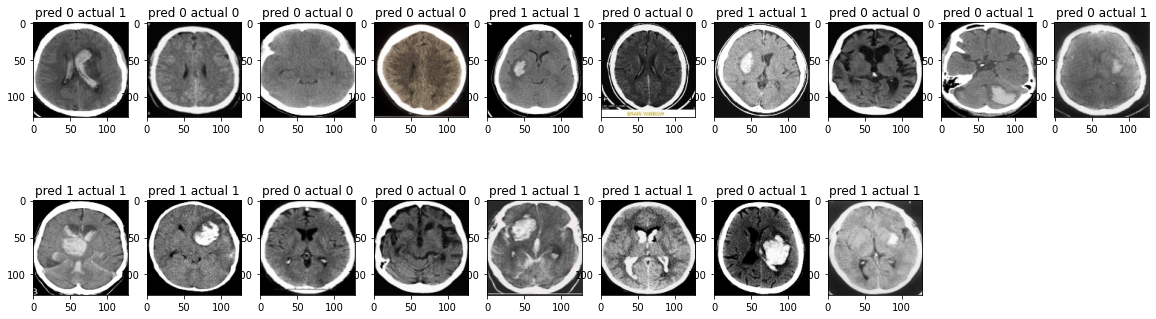

In [185]:
check_accuracy(model3, validationX/255., validationY)

In [186]:
loss3,accuracy3=model3.evaluate( validationX/255., validationY)
acc.append(accuracy3*100)

1/1 [==============================] - 0s 68ms/step - loss: 0.5187 - accuracy: 0.7778


## DenseNet

In [187]:
batchSize = 32
metric = 'val_accuracy'
model4.fit(train_image_data.flow(trainX, trainY, batch_size=batchSize), validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    #callbacks=[ModelCheckpoint("weights.h5", monitor=metric, save_best_only=True, mode='max', verbose=1)],
    epochs=16)

Epoch 1/16
6/6 [==============================] - 10s 470ms/step - loss: 5.4353 - accuracy: 0.4938 - val_loss: 8.9590 - val_accuracy: 0.3889
Epoch 2/16
6/6 [==============================] - 1s 132ms/step - loss: 2.5808 - accuracy: 0.5679 - val_loss: 2.1557 - val_accuracy: 0.6111
Epoch 3/16
6/6 [==============================] - 1s 123ms/step - loss: 1.2021 - accuracy: 0.6914 - val_loss: 1.6662 - val_accuracy: 0.5556
Epoch 4/16
6/6 [==============================] - 1s 124ms/step - loss: 1.4195 - accuracy: 0.6358 - val_loss: 0.7549 - val_accuracy: 0.7222
Epoch 5/16
6/6 [==============================] - 1s 125ms/step - loss: 0.7837 - accuracy: 0.7099 - val_loss: 0.6024 - val_accuracy: 0.7778
Epoch 6/16
6/6 [==============================] - 1s 127ms/step - loss: 0.4260 - accuracy: 0.8395 - val_loss: 0.8016 - val_accuracy: 0.7222
Epoch 7/16
6/6 [==============================] - 1s 127ms/step - loss: 0.5103 - accuracy: 0.8086 - val_loss: 0.3855 - val_accuracy: 0.7778
Epoch 8/16
6/6 [===

1/1 [==============================] - 2s 2s/step
True positive: 11 , True negative: 5 , False positive: 2 , False negative: 0
Total accuracy: 88.88888888888889 %


(5, 2, 0, 11)

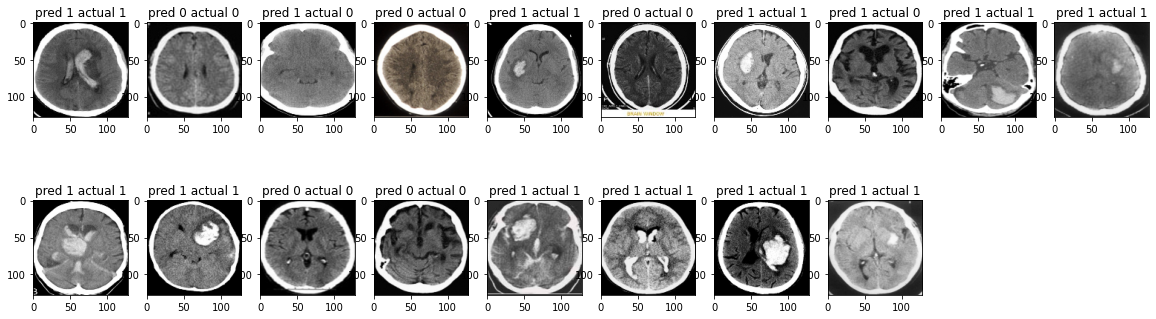

In [188]:
check_accuracy(model4, validationX/255., validationY)

In [189]:
loss4,accuracy4=model4.evaluate( validationX/255., validationY)
acc.append(accuracy4*100)

1/1 [==============================] - 0s 53ms/step - loss: 0.3735 - accuracy: 0.8889


## VGG

In [190]:
batchSize = 32
metric = 'val_accuracy'
model5.fit(train_image_data.flow(trainX, trainY, batch_size=batchSize), validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    #callbacks=[ModelCheckpoint("weights.h5", monitor=metric, save_best_only=True, mode='max', verbose=1)],
    epochs=16)

Epoch 1/16
6/6 [==============================] - 9s 471ms/step - loss: 1.4490 - accuracy: 0.6358 - val_loss: 0.3831 - val_accuracy: 0.8333
Epoch 2/16
6/6 [==============================] - 1s 127ms/step - loss: 0.5604 - accuracy: 0.8272 - val_loss: 0.2431 - val_accuracy: 0.8889
Epoch 3/16
6/6 [==============================] - 1s 125ms/step - loss: 0.4291 - accuracy: 0.8457 - val_loss: 0.3840 - val_accuracy: 0.8333
Epoch 4/16
6/6 [==============================] - 1s 128ms/step - loss: 0.5057 - accuracy: 0.8272 - val_loss: 0.7525 - val_accuracy: 0.7778
Epoch 5/16
6/6 [==============================] - 1s 123ms/step - loss: 0.4524 - accuracy: 0.8395 - val_loss: 0.3730 - val_accuracy: 0.7778
Epoch 6/16
6/6 [==============================] - 1s 124ms/step - loss: 0.3544 - accuracy: 0.8765 - val_loss: 0.5195 - val_accuracy: 0.8333
Epoch 7/16
6/6 [==============================] - 1s 127ms/step - loss: 0.4185 - accuracy: 0.8519 - val_loss: 0.5979 - val_accuracy: 0.7778
Epoch 8/16
6/6 [====

1/1 [==============================] - 2s 2s/step
True positive: 11 , True negative: 5 , False positive: 2 , False negative: 0
Total accuracy: 88.88888888888889 %


(5, 2, 0, 11)

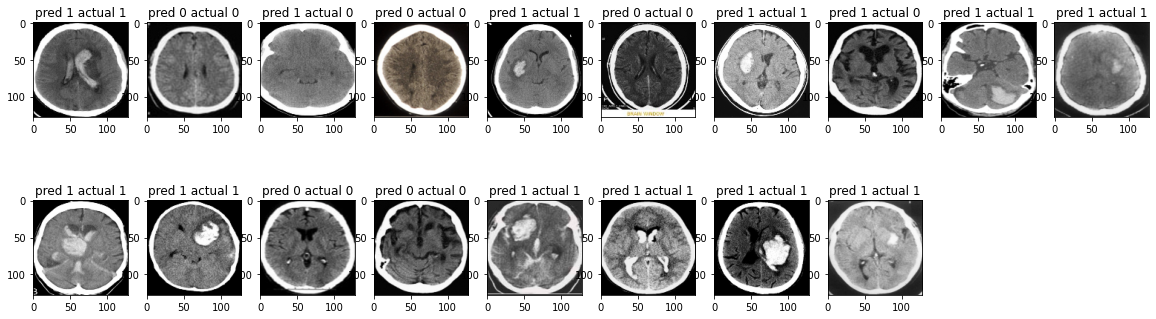

In [191]:
check_accuracy(model5, validationX/255., validationY)

In [192]:
loss5,accuracy5=model5.evaluate( validationX/255., validationY)
acc.append(accuracy5*100)

1/1 [==============================] - 0s 53ms/step - loss: 0.2933 - accuracy: 0.8889


### Accuract Plot

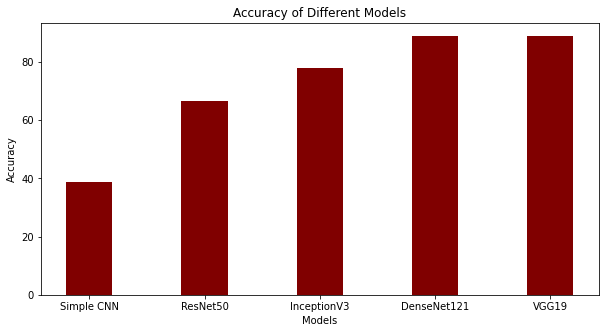

In [197]:
fig = plt.figure(figsize = (10, 5))
plt.bar(models, acc, color ='maroon',
        width = 0.4)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy of Different Models")
plt.show()

In [194]:
model1.save("weightsCNN.h5")
model1.load_weights("weightsCNN.h5")
model2.save("weightsResnet.h5")
model2.load_weights("weightsResnet.h5")
model3.save("weightsInception.h5")
model3.load_weights("weightsInception.h5")
model4.save("weightsDenseNet.h5")
# model4.load_weights("weightsDensenet.h5")
model5.save("weightsVGG.h5")
model5.load_weights("weightsVGG.h5")